In [65]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [67]:
yeast=open("yeast_residual_data_full_1000_gt_2.txt","r")



#yeast data read 
L=[]
A=[]
B=[]
for i in range(0,1000):
  line=yeast.readline()
  #line=line[1:-2] #remove double quotes 
  #param = [j for j in line.split()]
  #print(param)
  #chrname.append(param[1])
  #g1.append(param[2])
  #g2.append(param[3])
  line=yeast.readline()
  l = [j for j in line.split()]
  L.append([int(i) for i in l])
  line=yeast.readline()
  a = [j for j in line.split()]
  A.append([float(i) for i in a])
  line=yeast.readline()
  b = [j for j in line.split()]
  B.append([float(i) for i in b])
dataset_0 = [i for i in zip(L,A,B)]


In [68]:
#yeast data
yeast=open("yeast_residual_data_full_1000_gt_1.txt","r")



#yeast data read 
L=[]
A=[]
B=[]
for i in range(0,1000):
  line=yeast.readline()
  #line=line[1:-2] #remove double quotes 
  #param = [j for j in line.split()]
  #print(param)
  #chrname.append(param[1])
  #g1.append(param[2])
  #g2.append(param[3])
  line=yeast.readline()
  l = [j for j in line.split()]
  L.append([int(i) for i in l])
  line=yeast.readline()
  a = [j for j in line.split()]
  A.append([float(i) for i in a])
  line=yeast.readline()
  b = [j for j in line.split()]
  B.append([float(i) for i in b])
dataset_1 = [i for i in zip(L,A,B)]

#reshapefunction



In [28]:

from tensorflow_probability import distributions as tfd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import statsmodels.api as sm
import pickle

In [2]:
class MDN_module(tf.keras.Model):

    def __init__(self, neurons=15, components = 1):
        super(MDN_module, self).__init__(name="MDN_module")
        self.neurons = neurons
        self.components = components

        #chaging activation to relu from linear, changin relu to sigmoid 
        for i in range(1,3):
          s="self"+".h"+str(i)+"= Dense(neurons, activation=\"relu\", name="+"'h"+str(i)+"')"
          exec(s)
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, activation="linear",name="mus") 
        self.sigmas = Dense(components, activation="nnelu",name="sigmas") #activation changed from linear to default
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x=self.h1(inputs)
        #x=self.inputA(inputs)
        x=self.h2(x)
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v,mu_v, sigma_v])

In [3]:
no_parameters=3
components=1

def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1
    )*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha,mu,sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    #tf.print(sigma)
    gm = tfd.MixtureSameFamily(
           mixture_distribution=tfd.Categorical(probs=alpha),
           components_distribution=tfd.Normal(
           loc=mu,       
           scale=sigma))
    
    
    
    log_likelihood =  gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y 
    return -tf.reduce_mean(log_likelihood, axis=-1) 

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

def gnll_eval(y,alpha, mu, sigma):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(tf.transpose(y))
    return -tf.reduce_mean(log_likelihood, axis=-1)


def eval_mdn_model(x_test, y_test, mdn_model):
    y_pred = mdn_model.predict(np.reshape(x_test,newshape=(len(x_test),-1)))
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    mdn_nll = gnll_eval(y_test.astype(np.float32),alpha, mu, sigma).numpy()
    return mdn_nll
#reshapefunction
def reshapevar(X):
  return np.reshape(X,newshape=(len(X),-1))

In [4]:
def compute_loss(P,Q):
  opt = tf.optimizers.Adam(1e-2)
  mdn_PQ = MDN_module()
  mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
  mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
  return eval_mdn_model(P,Q,mdn_PQ)


In [5]:
def shuffleBtimes(P,Q,B):
  loss=[]
  for i in range(0,B):
    np.random.shuffle(Q)
    loss.append(compute_loss(P,Q))
  return loss


In [6]:
def LinearLABData():
  L = np.random.binomial(1,0.5,1000)  
  beta0 = np.ones(1000)-0.4
  #beta1 = 0.5
  beta1=3
  beta2= 0.3
  beta3=0.8
  eps0 = np.random.standard_normal(1000)
  eps1 = np.random.standard_normal(1000)
  A = beta0 + beta1*L + eps0
  B = beta2+ beta3*A+ eps1 
  plt.scatter(A,B)
  plt.title("A vs B")
  plt.xlabel("A")
  plt.ylabel("B")
  return [L,A,B]

In [7]:
def residual(P,Q):
  model=sm.OLS(Q,P).fit()
  return model.resid
  

In [98]:
yeast_name=""
def yeast_data(i,ind):
    global yeast_name
    yeast_name="yeast_"+str(i)+"_"+str(ind)
    ds = eval("dataset_"+str(i)+"["+str(ind)+"]")
    L_dist = np.array(ds[0]) #np.array(ds[0])
    A_dist = np.array(ds[1])
    B_dist = np.array(ds[2])
    return [L_dist,A_dist,B_dist]

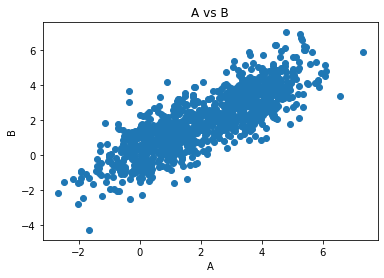

In [108]:
random.seed(24)
shuffles=10
L,A,B=LinearLABData()
#L,A,B=yeast_data(1,444)
B_resid=residual(A,B)
A_shuffle=np.copy(A)
B_shuffle=np.copy(B)
B_resid_shuffle=np.copy(B_resid)
loss_list_LA=shuffleBtimes(L,A_shuffle,shuffles)
loss_list_LB=shuffleBtimes(L,B_shuffle,shuffles)
loss_list_LindB_A=shuffleBtimes(L,B_resid_shuffle,shuffles) #conditional independence test
true_LA=compute_loss(L,A)
true_LB=compute_loss(L,B)
true_LindB_A=compute_loss(L,B_resid)


In [104]:
yeast_name

'yeast_1_444'

In [109]:
pickle_items=[loss_list_LA,loss_list_LB,loss_list_LindB_A,true_LA,true_LB,true_LindB_A]
file_name=str(shuffles)+"shuffles"+yeast_name+".pkl"
open_file = open(file_name, "wb")
pickle.dump(pickle_items, open_file)
open_file.close()


In [61]:
open_file = open(file_name, "rb")

loaded_list = pickle.load(open_file)

open_file.close()

In [62]:
loaded_list

[[2.013232,
  2.0132065,
  2.012622,
  2.013327,
  2.0131795,
  2.0104077,
  2.0131552,
  2.0120978,
  2.013201,
  2.0138726,
  2.0127542,
  2.0130835,
  2.013395,
  2.0121174,
  2.0123744,
  2.0127525,
  2.0141394,
  2.014249,
  2.0141883,
  2.014655,
  2.0136216,
  2.0111518,
  2.0120928,
  2.0125115,
  2.0130022,
  2.013688,
  2.0133693,
  2.013257,
  2.0132482,
  2.0133882,
  2.0125241,
  2.0131712,
  2.0121853,
  2.0131001,
  2.0131788,
  2.0132241,
  2.013357,
  2.012845,
  2.0127606,
  2.013228,
  2.0098248,
  2.0174155,
  2.0133665,
  2.010421,
  2.0151174,
  2.0137053,
  2.0141463,
  2.0149615,
  2.0146227,
  2.0131576,
  2.0133564,
  2.0135412,
  2.0124972,
  2.013912,
  2.0107305,
  2.0128188,
  2.0181894,
  2.0132077,
  2.015675,
  2.0132082,
  2.0131416,
  2.013619,
  2.0145135,
  2.0131845,
  2.013524,
  2.0129824,
  2.0127983,
  2.0148015,
  2.0132957,
  2.012691,
  2.0122492,
  2.0116956,
  2.0142794,
  2.0130088,
  2.0132709,
  2.0133843,
  2.0128608,
  2.0132136,
  2.

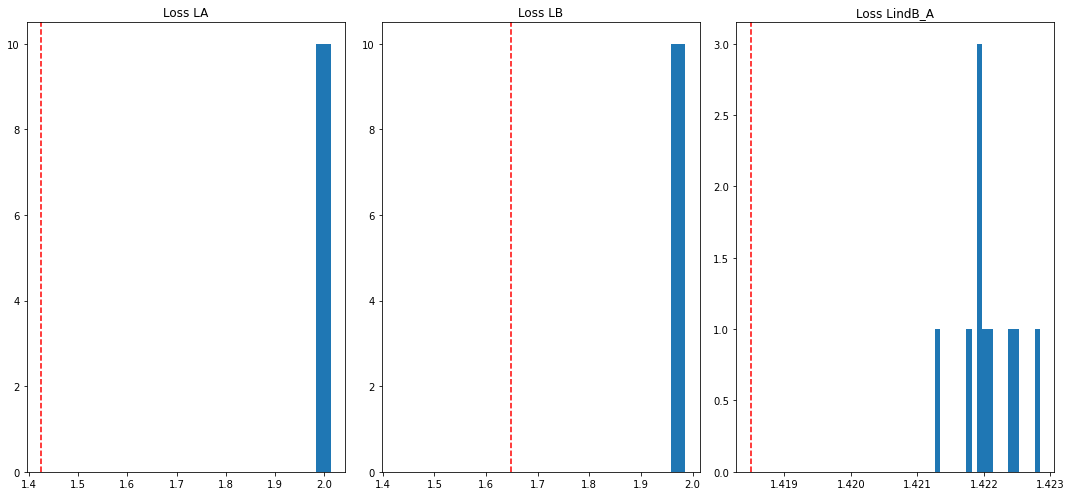

In [111]:
basket=20
fig, axs = plt.subplots(1, 3,figsize =(15, 7),tight_layout = True)
axs[0].hist(loss_list_LA,bins=basket,range=[min(min(loss_list_LA),true_LA),max(max(loss_list_LA),true_LA)])
axs[0].set_title("Loss LA")
axs[0].axvline(true_LA,linestyle='dashed',color='red')
axs[1].hist(loss_list_LB,bins=basket,range=[min(min(loss_list_LA),true_LA),max(max(loss_list_LB),true_LB)])
axs[1].set_title("Loss LB")
axs[1].axvline(true_LB,linestyle='dashed',color='red')
axs[2].hist(loss_list_LindB_A,bins=basket)#,range=[min(min(loss_list_LA),true_LA),max(max(loss_list_LindB_A),true_LindB_A)])
axs[2].set_title("Loss LindB_A")
axs[2].axvline(true_LindB_A,linestyle='dashed',color='red')
plt.show()